In [1]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import time
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving 118.jpg to 118.jpg


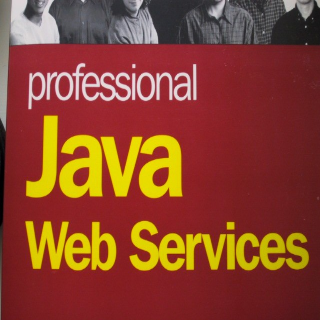

In [3]:
from google.colab import files
uploaded = files.upload()

features = []

for fn in uploaded.keys():
    imgWidth=320
    imgHeight=320

    path = fn
    image = cv2.imread(path)

    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (imgWidth, imgHeight)

    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]
    cv2_imshow(image)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Capstone/train/00_02_jpg.rf.8c45774375a82411ab10e63de83f6394.jpg')

# image height and width should be multiple of 32
imgWidth=320
imgHeight=320

orig = image.copy()
(H, W) = image.shape[:2]
(newW, newH) = (imgWidth, imgHeight)

rW = W / float(newW)
rH = H / float(newH)
image = cv2.resize(image, (newW, newH))

(H, W) = image.shape[:2]
cv2_imshow(image)


In [4]:
net = cv2.dnn.readNet('/content/drive/MyDrive/Capstone/frozen_east_text_detection.pb')

In [5]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

In [6]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [7]:
net.setInput(blob)
output = net.forward(outputLayers)
scores = output[0]
geometry = output[1]

In [8]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [9]:
# apply non-maxima suppression to suppress weak, overlapping bounding
boxes = non_max_suppression(np.array(rects), probs=confidences)

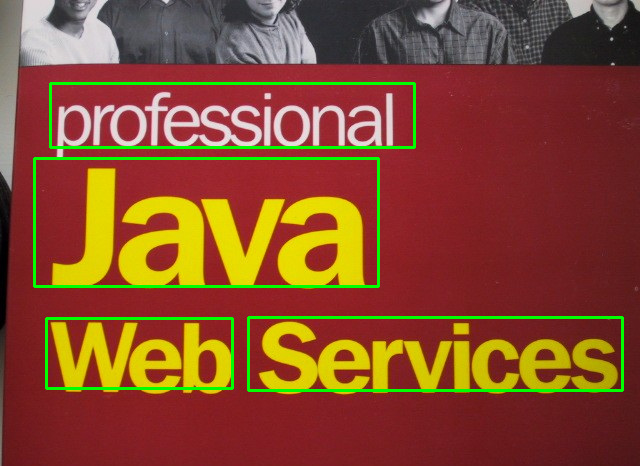

-1

In [10]:
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(orig)
cv2.waitKey(0)